In [1]:
!pip install -U "tensorflow-text==2.15.*"
!pip install -U "tf-models-official==2.15.*"

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 72.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 78.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 89.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 113.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 80.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.8 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow.keras.backend as K
from scipy.stats import spearmanr
from math import floor, ceil
from transformers import *

np.set_printoptions(suppress=True)
print(tf.__version__)

import shutil

from official.nlp import optimization  # to create AdamW optmizer

tf.get_logger().setLevel('ERROR')

/usr/local/lib/python3.10/dist-packages/transformers/deepspeed.py:24: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
GroupViT models are not usable since `tensorflow_probability` can't be loaded. It seems you have `tensorflow_probability` installed with the wrong tensorflow version.Please try to reinstall it following the instructions he

2.15.1


In [3]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split

# Load your dataset
df = pd.read_csv('/content/violencedataset.csv', encoding='ISO-8859-1')

# Display the first few rows of the dataframe
print(df.head())

# Strip whitespace from all column names
df.columns = df.columns.str.strip()

df.shape

      Tweet_ID                                               text  \
0  ID_0022DWKP  Had a dream i got raped last night. By a guy i...   
1  ID_0058QG76  My Husband Beats Me Frequently, Wife Tells Cou...   
2  ID_004BBHOD  I was sexually abused for 3 years at age 4 to ...   
3  ID_004F7516  !!! RT @mayasolovely: As a woman you shouldn't...   
4  ID_0052TYKI    " momma said no pussy cats inside my doghouse "   

          label_name  label  
0    sexual_violence      0  
1  physical_violence      1  
2    sexual_violence      0  
3       non_violence      2  
4       non_violence      2  


(6616, 4)

In [4]:
# Grouping data by label
df.groupby('label').count()

,Tweet_ID,text,label_name
label,,,
0,2820,2820,2820
1,2649,2649,2649
2,1147,1147,1147


In [5]:
#Splitting the data between train, validation and test sets:
X_train_, X_test, y_train_, y_test = train_test_split(
    df.index.values,
    df.label.values,
    test_size=0.40,
    random_state=700,
    stratify=df.label.values,
)
X_train, X_val, y_train, y_val = train_test_split(
    df.loc[X_train_].index.values,
    df.loc[X_train_].label.values,
    test_size=0.40,
    random_state=200,
    stratify=df.loc[X_train_].label.values,
)
df['data_type'] = ['not_set']*df.shape[0]
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'
df.loc[X_test, 'data_type'] = 'test'
df.groupby(['label_name', 'label', 'data_type']).count()

Tweet_ID  text
label_name        label data_type                
non_violence      2     test            459   459
                        train           413   413
                        val             275   275
physical_violence 1     test           1060  1060
                        train           953   953
                        val             636   636
sexual_violence   0     test           1128  1128
                        train          1015  1015
                        val             677   677

In [6]:
df

,Tweet_ID,text,label_name,label,data_type
0,ID_0022DWKP,Had a dream i got raped last night. By a guy i...,sexual_violence,0,train
1,ID_0058QG76,"My Husband Beats Me Frequently, Wife Tells Cou...",physical_violence,1,test
2,ID_004BBHOD,I was sexually abused for 3 years at age 4 to ...,sexual_violence,0,val
3,ID_004F7516,!!! RT @mayasolovely: As a woman you shouldn't...,non_violence,2,val
4,ID_0052TYKI,""" momma said no pussy cats inside my doghouse """,non_violence,2,train
...,...,...,...,...,...
6611,ID_32AX5YTC,&#8220;@JerGucci: @1__dev You the Real MVP&#82...,physical_violence,1,train
6612,ID_32CZXXLO,&#8220;@JestonaeLives: Burnt pussy lips - &#12...,physical_violence,1,test
6613,ID_32TARBR3,&#8220;@JoeBudden: The bad bitches are only ba...,physical_violence,1,val
6614,ID_32XR82XM,"&#8220;@JulianSantomaur: 5""0 with 30 hoes on m...",physical_violence,1,train


In [7]:
#TRAIN DATA
df_train = df.loc[df["data_type"]=="train"]
df_train.head(5)

,Tweet_ID,text,label_name,label,data_type
0,ID_0022DWKP,Had a dream i got raped last night. By a guy i...,sexual_violence,0,train
4,ID_0052TYKI,""" momma said no pussy cats inside my doghouse """,non_violence,2,train
8,ID_00A89HJ5,"""@ArizonasFinest6: Why the eggplant emoji doe?...",non_violence,2,train
12,ID_00BXFFCR,"""@EdgarPixar: Overdosing on heavy drugs doesn'...",non_violence,2,train
16,ID_00FBBFAB,"""@HermosaAlma: This isn't ghetto.....it's smar...",non_violence,2,train


In [8]:
#VAL DATA
df_val = df.loc[df["data_type"]=="val"]
df_val.head(5)

,Tweet_ID,text,label_name,label,data_type
2,ID_004BBHOD,I was sexually abused for 3 years at age 4 to ...,sexual_violence,0,val
3,ID_004F7516,!!! RT @mayasolovely: As a woman you shouldn't...,non_violence,2,val
5,ID_005VM1DJ,"""@Addicted2Guys: -SimplyAddictedToGuys http://...",non_violence,2,val
6,ID_0060BW8R,"""@AllAboutManFeet: http://t.co/3gzUpfuMev"" woo...",non_violence,2,val
7,ID_007FAIEI,"""@Allyhaaaaa: Lemmie eat a Oreo &amp; do these...",non_violence,2,val


In [9]:
df_test = df.loc[df["data_type"]=="test"]
df_test.head(5)

,Tweet_ID,text,label_name,label,data_type
1,ID_0058QG76,"My Husband Beats Me Frequently, Wife Tells Cou...",physical_violence,1,test
10,ID_00AWI88Y,"""@DomWorldPeace: Baseball season for the win. ...",non_violence,2,test
11,ID_00B6KO4G,"""@DunderbaIl: I'm an early bird and I'm a nigh...",non_violence,2,test
15,ID_00F2VJM8,"""@FunnyPicsDepot: this the ""I play soccer, che...",non_violence,2,test
19,ID_00IUWBD2,"""@KnightfanNeal #UCFPINKPARTY come on stay ali...",non_violence,2,test


In [10]:
df.dtypes

,0
Tweet_ID,object
text,object
label_name,object
label,int64
data_type,object


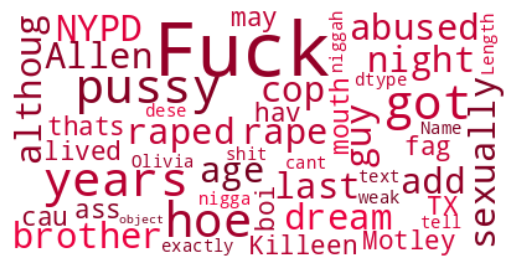

In [11]:
# WORDCLOUD FOR SEXUAL VIOLENCE - LABEL '0'
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import random

stopwords = set(STOPWORDS)
stopwords.add("RT")

def random_color_func(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
    h = 344
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

wordcloud = WordCloud(
    background_color='white',
    stopwords=stopwords,
    max_words=200,
    max_font_size=60,
    random_state=42
).generate(str(df.loc[df["label_name"] == "sexual_violence"]['text']))  # Updated column name

fig = plt.figure(1)
plt.imshow(wordcloud.recolor(color_func=random_color_func, random_state=3), interpolation="bilinear")
plt.axis('off')
plt.show()


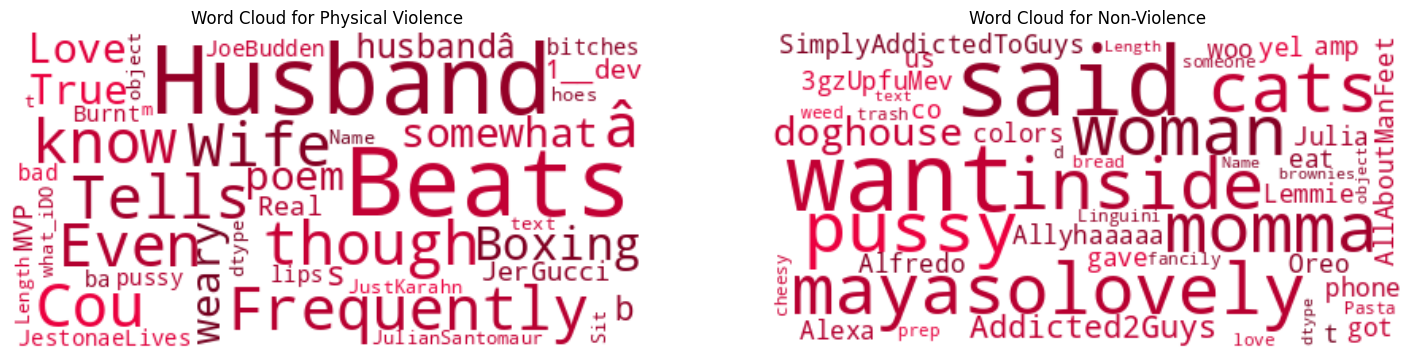

In [12]:
# Generate word cloud for physical violence
wordcloud_physical = WordCloud(
    background_color='white',
    stopwords=stopwords,
    max_words=200,
    max_font_size=60,
    random_state=42
).generate(str(df.loc[df["label_name"] == "physical_violence"]['text']))

# Generate word cloud for non-violence
wordcloud_non_violence = WordCloud(
    background_color='white',
    stopwords=stopwords,
    max_words=200,
    max_font_size=60,
    random_state=42
).generate(str(df.loc[df["label_name"] == "non_violence"]['text']))

# Plotting the word clouds
fig, ax = plt.subplots(1, 2, figsize=(18, 9))

ax[0].imshow(wordcloud_physical.recolor(color_func=random_color_func, random_state=3), interpolation="bilinear")
ax[0].set_title('Word Cloud for Physical Violence')
ax[0].axis('off')

ax[1].imshow(wordcloud_non_violence.recolor(color_func=random_color_func, random_state=3), interpolation="bilinear")
ax[1].set_title('Word Cloud for Non-Violence')
ax[1].axis('off')

plt.show()

Build TensorFlow input

In [13]:
# Ensure the text column is converted to string
df_train['text'] = df_train['text'].astype(str)
df_val['text'] = df_val['text'].astype(str)
df_test['text'] = df_test['text'].astype(str)

<ipython-input-13-c44e92f4a725>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['text'] = df_train['text'].astype(str)
<ipython-input-13-c44e92f4a725>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['text'] = df_val['text'].astype(str)
<ipython-input-13-c44e92f4a725>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [14]:
train_ds = tf.data.Dataset.from_tensor_slices((df_train.text.values, df_train.label.values))
val_ds = tf.data.Dataset.from_tensor_slices((df_val.text.values, df_val.label.values))
test_ds = tf.data.Dataset.from_tensor_slices((df_test.text.values, df_test.label.values))


In [15]:
train_ds

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [16]:
train_ds = train_ds.shuffle(len(df_train)).batch(32, drop_remainder=False)
train_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [17]:
val_ds = val_ds.shuffle(len(df_val)).batch(32, drop_remainder=False)
val_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [18]:
test_ds = test_ds.shuffle(len(df_test)).batch(32, drop_remainder=False)
test_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [19]:
for feat, targ in train_ds.take(1):
  print ('Features: {}, Target: {}'.format(feat, targ))

Features: [b"lol beats me. I think it's because she thought I was keeping a secret? I said no, my husband was home that's all lol"
 b'@OfficialSkai dont tell me what to do. fuck balls kike nigger cunt tits cocksucker chink spic piss bitch bastard pussy faggot.'
 b'@femalejokerhoee yeah he sucks just like the other fags who are... oh nevermind there are NO fags in the #NFL'
 b'Yeah, it\'s less happy for the gender rather than skipping the whole "But he raped me" narrative.'
 b'I Provide For The Family, Yet My Husband Beats Me If I Don\xc3\xa2\xc2\x80\xc2\x99t Give Him Pocket Money \xc3\xa2\xc2\x80\xc2\x93 Nigerian Woman    '
 b'The man that raped me was a dentist , in a job where people trusted him. Maybe I was just some woman he thought who cares she\xc3\xa2\xc2\x80\xc2\x99s a nobody. I still think this to this day why me? Because I wasn\xc3\xa2\xc2\x80\xc2\x99t as intellectual as u, did I dress like I asked for  it?'
 b"My ex hit me, cheated on me and 7 years after we divorced, his si

Loading models from TensorFlow Hub

In [20]:
#bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'
bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/1',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1


Preprocessing model

In [21]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [22]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(1):
    tweet = text_batch.numpy()[i]
    print(f'Tweet: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label}')

text_test = ['this is such an amazing movie!']
text_test = [tweet]


text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Tweet: b'My husband beats me before sex \xc3\xa2\xc2\x80\xc2\x93 Woman tells court    '
Label : 1
Keys       : ['input_mask', 'input_word_ids', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [  101  2026  3129 10299  2033  2077  3348  1037  2450  4136  2457   102]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [23]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [24]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[-0.8444922  -0.33657196  0.03205986  0.65291363 -0.02650368 -0.21580467
  0.8098377   0.26380256  0.05484441 -0.99979043  0.08426043  0.65558004]
Sequence Outputs Shape:(1, 128, 768)
Sequence Outputs Values:[[ 0.00892689  0.25923035  0.02230191 ... -0.3868686   0.12728739
   0.15273382]
 [ 0.2578505   0.36708614  0.07793737 ... -0.68423635  0.50258976
  -0.02559879]
 [ 0.3999338   0.07567249  0.73206073 ... -0.8071981   0.01942517
  -0.02705624]
 ...
 [ 0.57094175 -0.08277144  0.53684896 ... -0.31521195 -0.04238507
  -0.81790584]
 [-0.06470041 -0.6521688   0.05049049 ... -0.03188533  0.46598646
   0.04653572]
 [ 0.6386231   0.347129   -0.28733608 ... -0.36497116 -0.7175084
  -0.19605978]]


BERT + CNN

In [25]:
# Build the CNN classifier model
def build_CNN_classifier_model():
    # Input layer for text
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

    # BERT preprocessing layer
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)

    # BERT encoder layer
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs["sequence_output"]

    # CNN layers with dropout and regularization
    net = tf.keras.layers.Conv1D(32, (2), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(net)
    net = tf.keras.layers.Dropout(0.3)(net)
    net = tf.keras.layers.Conv1D(64, (2), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(net)
    net = tf.keras.layers.GlobalMaxPool1D()(net)
    net = tf.keras.layers.Dense(768, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dense(3, activation="softmax", name='classifier')(net)

    return tf.keras.Model(text_input, net)

# Build the model
cnn_classifier_model = build_CNN_classifier_model()

# Create TensorFlow datasets from data
def create_tf_dataset(texts, labels, batch_size=32, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((texts, labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(texts))
    dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

# Prepare datasets
train_ds = create_tf_dataset(df_train['text'].values, df_train['label'].values)
val_ds = create_tf_dataset(df_val['text'].values, df_val['label'].values, shuffle=False)
test_ds = create_tf_dataset(df_test['text'].values, df_test['label'].values, shuffle=False)

# Implement Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

# Set reduced learning rate
initial_learning_rate = 1e-5

# Compile the model
cnn_classifier_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
                             loss='sparse_categorical_crossentropy',
                             metrics=['accuracy'])

In [26]:
text_test

[b'My husband beats me before sex \xc3\xa2\xc2\x80\xc2\x93 Woman tells court    ']

In [27]:
cnn_classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 preprocessing (KerasLayer)  {'input_type_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_word_ids': (None,                                           
                              128)}                                                               
                                                                                              

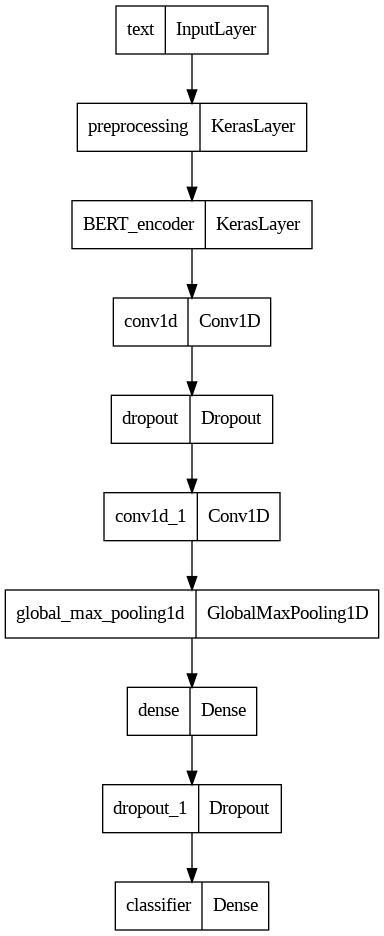

In [28]:
tf.keras.utils.plot_model(cnn_classifier_model)

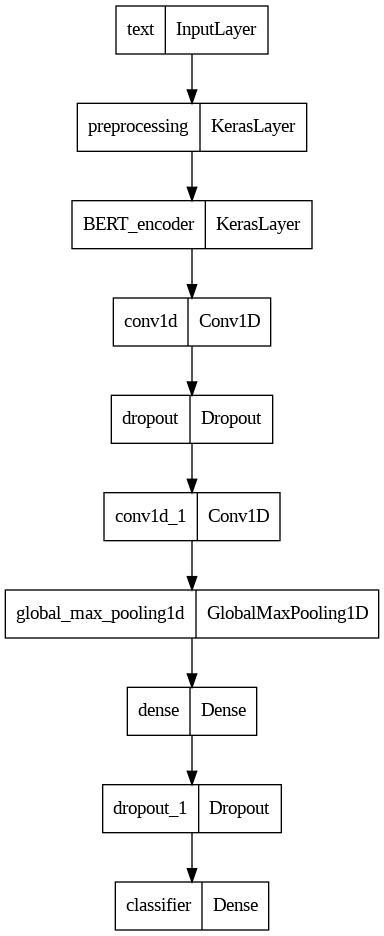

In [29]:
tf.keras.utils.plot_model(cnn_classifier_model)

In [30]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#metrics = tf.metrics.CategoricalCrossentropy()
#metrics = tf.metrics.Accuracy()

In [31]:
for batch in train_ds.take(1):
    print(batch)


(<tf.Tensor: shape=(32,), dtype=string, numpy=
array([b'&#128514;&#128514;&#128514;&#128514; &#128128;&#128128; &#8220;@LisforLex: No bitch go away &#9995;"@subnorbot1: @Tats_NSnapbacks @LisforLex @LisforLex tu puta madre @carlosnoodles"&#8221;',
       b'Ok, so let me try to grasp this, he asked her if she "likes older men" and that makes her a "survivor" - Tara Reade reported being raped by Joe Biden and we just gaslight the story? Nice, good luck and good night Democracy',
       b'I would like for it to be me but my husband always beats me to the spot',
       b'@Yankees ugh',
       b'MY HUSBAND BEATS ME /black friday crazy night and rude people in line/ christmas shopping PART 2:   via',
       b'MY husband beats me.Housewife Begs Court To Dissolve Her 14-Year-Old Marriage  A 38-year-old housewife, Catherine...  ',
       b'"I want to expose someone, his name is _____ and he raped me"  What they did \xc3\xb0\xc2\x9f\xc2\x91\xc2\x87\xc3\xb0\xc2\x9f\xc2\x8f\xc2\xbe',
       b'@MrMo

In [32]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

cnn_classifier_model.compile(optimizer=optimizer,
                          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                          metrics=tf.keras.metrics.SparseCategoricalAccuracy('accuracy'))

In [33]:
# Fit the model with proper dataset inputs
cnn_history = cnn_classifier_model.fit(
    x=train_ds,
    validation_data=val_ds,
    epochs=epochs,
)


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


75/75 [==============================] - 66s 613ms/step - loss: 3.1996 - accuracy: 0.4511 - val_loss: 2.7784 - val_accuracy: 0.7909
Epoch 2/5
75/75 [==============================] - 44s 593ms/step - loss: 2.5677 - accuracy: 0.8257 - val_loss: 2.4183 - val_accuracy: 0.9395
Epoch 3/5
75/75 [==============================] - 44s 592ms/step - loss: 2.3244 - accuracy: 0.9303 - val_loss: 2.3120 - val_accuracy: 0.9484
Epoch 4/5
75/75 [==============================] - 44s 591ms/step - loss: 2.2232 - accuracy: 0.9626 - val_loss: 2.2700 - val_accuracy: 0.9528
Epoch 5/5
75/75 [==============================] - 44s 592ms/step - loss: 2.1602 - accuracy: 0.9798 - val_loss: 2.2557 - val_accuracy: 0.9534


In [34]:
loss, accuracy = cnn_classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

83/83 [==============================] - 14s 167ms/step - loss: 2.2571 - accuracy: 0.9520
Loss: 2.2571206092834473
Accuracy: 0.9520211815834045


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


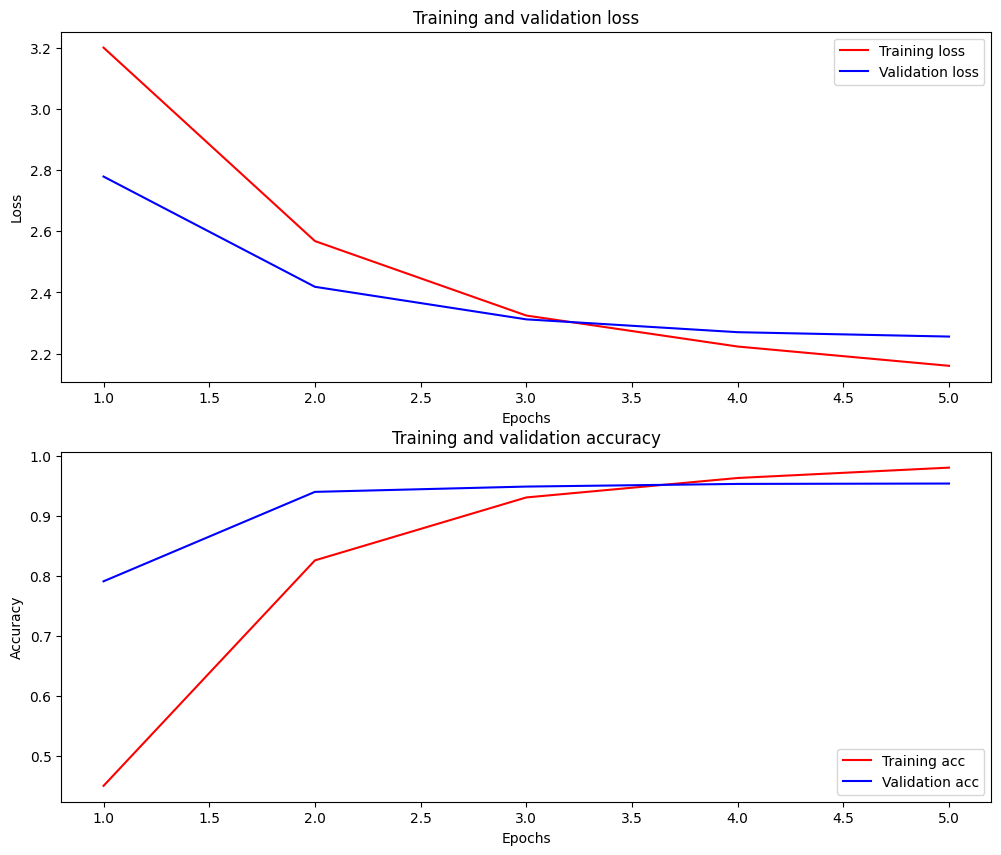

In [35]:
history_dict = cnn_history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
# acc = history_dict['binary_accuracy']
# val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(12, 10))
fig.tight_layout()

plt.subplot(2, 1, 1)
#"bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
#b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [36]:
dataset_name = '/content/violencedataset.csv'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

cnn_classifier_model.save(saved_model_path, include_optimizer=False)

In [37]:
reloaded_model = tf.saved_model.load(saved_model_path)

Results for CNN

In [38]:
result =  cnn_classifier_model.predict(test_ds)
print(result.shape)

83/83 [==============================] - 15s 162ms/step
(2647, 3)


In [39]:
result[0:2]

array([[0.00568159, 0.9881394 , 0.00617893],
       [0.07282275, 0.131437  , 0.79574025]], dtype=float32)

In [40]:
for tweet, classes in test_ds:
    for i in classes:
       print(i)

tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype

In [43]:
classes = np.argmax(result, axis=-1)

Doing predictions and saving to np.array

In [42]:
tweet = []
test_labels = []
predictions = []
for tweet, labels in test_ds.take(-1):
  tweet = tweet.numpy()
  test_labels.append(labels.numpy())
  predictions.append(cnn_classifier_model.predict(tweet))

1/1 [==============================] - 1s 1s/step


In [44]:
test_labels[0:2]

[array([1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2]),
 array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2])]

In [45]:
predictions[0:2]

[array([[0.00568159, 0.9881394 , 0.00617893],
        [0.07282275, 0.131437  , 0.79574025],
        [0.10362615, 0.19256161, 0.7038122 ],
        [0.08547389, 0.18021356, 0.7343126 ],
        [0.07141155, 0.05249339, 0.876095  ],
        [0.06944996, 0.5148984 , 0.41565162],
        [0.08172283, 0.30239427, 0.6158829 ],
        [0.84875137, 0.04199342, 0.10925512],
        [0.0085747 , 0.9822744 , 0.00915084],
        [0.0292916 , 0.8727596 , 0.0979488 ],
        [0.11175317, 0.11363094, 0.7746159 ],
        [0.13400953, 0.09676644, 0.76922405],
        [0.09372102, 0.09888344, 0.8073955 ],
        [0.08612347, 0.11284509, 0.8010315 ],
        [0.10167828, 0.153731  , 0.7445907 ],
        [0.10377011, 0.1318379 , 0.76439196],
        [0.01081245, 0.97232294, 0.01686472],
        [0.07252799, 0.48229662, 0.44517538],
        [0.08574665, 0.3444814 , 0.56977195],
        [0.08683676, 0.57334197, 0.3398212 ],
        [0.11545967, 0.09916142, 0.7853789 ],
        [0.8524805 , 0.08823722, 0

In [48]:
from itertools import chain
flatten_list = list(chain.from_iterable(predictions))
y_pred = np.argmax(flatten_list, axis=-1)

In [47]:
type(y_pred)

numpy.ndarray

In [49]:
y_test = np.array(list(chain.from_iterable(test_labels)))

In [50]:
type(y_test)

numpy.ndarray

Confusion Matrix CNN

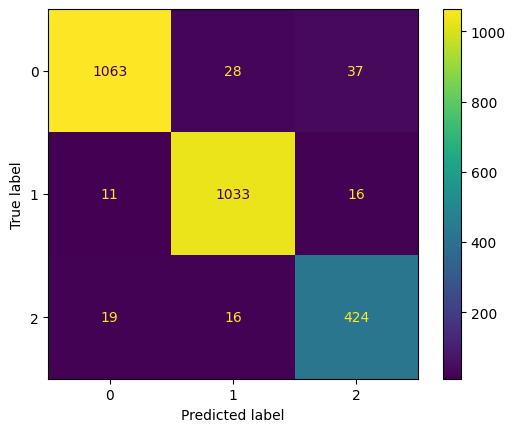

              precision    recall  f1-score   support

           0       0.97      0.94      0.96      1128
           1       0.96      0.97      0.97      1060
           2       0.89      0.92      0.91       459

    accuracy                           0.95      2647
   macro avg       0.94      0.95      0.94      2647
weighted avg       0.95      0.95      0.95      2647



In [51]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

actual = numpy.random.binomial(1,.9,size = 1000)
predicted = numpy.random.binomial(1,.9,size = 1000)

CNN_test=y_test
CNN_pred=y_pred

confusion_matrix = metrics.confusion_matrix(CNN_test, CNN_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1, 2])

cm_display.plot()
plt.show()

from sklearn.metrics import classification_report
print(classification_report(CNN_test, CNN_pred))

MODIFICATIONS FOR HIGH ACCUARCU

In [52]:
from sklearn.metrics import classification_report

# Function to evaluate model on the test set
def evaluate_model(model, test_dataset):
    y_true = []
    y_pred = []

    for text, label in test_dataset:
        predictions = model.predict(text)
        y_true.extend(label.numpy())
        y_pred.extend(tf.argmax(predictions, axis=1).numpy())

    print(classification_report(y_true, y_pred, target_names=['sexual_violence', 'physical_violence', 'non_violence']))

# Call the evaluation function
evaluate_model(cnn_classifier_model, test_ds)

1/1 [==============================] - 0s 51ms/step
                   precision    recall  f1-score   support

  sexual_violence       0.97      0.94      0.96      1128
physical_violence       0.96      0.97      0.97      1060
     non_violence       0.89      0.92      0.91       459

         accuracy                           0.95      2647
        macro avg       0.94      0.95      0.94      2647
     weighted avg       0.95      0.95      0.95      2647



In [53]:
#2. Check Data Splits
# Ensure there is no overlap between train, validation, and test sets
train_indices = set(X_train)
val_indices = set(X_val)
test_indices = set(X_test)

assert train_indices.isdisjoint(val_indices), "Train and validation sets overlap!"
assert train_indices.isdisjoint(test_indices), "Train and test sets overlap!"
assert val_indices.isdisjoint(test_indices), "Validation and test sets overlap!"

In [54]:
def build_CNN_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs["sequence_output"]  # Use sequence output for CNN

    net = tf.keras.layers.Conv1D(32, (2), activation='relu')(net)
    net = tf.keras.layers.Dropout(0.2)(net)  # Add dropout layer

    net = tf.keras.layers.Conv1D(64, (2), activation='relu')(net)
    net = tf.keras.layers.GlobalMaxPool1D()(net)

    net = tf.keras.layers.Dense(768, activation="relu")(net)
    net = tf.keras.layers.Dropout(0.3)(net)  # Add dropout layer

    net = tf.keras.layers.Dense(3, activation="softmax", name='classifier')(net)

    return tf.keras.Model(text_input, net)

cnn_classifier_model = build_CNN_classifier_model()


In [55]:
#Implement Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

In [56]:
#Reduce Learning Rate
initial_learning_rate = 1e-6  # Reduced learning rate

cnn_classifier_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
                             loss='sparse_categorical_crossentropy',
                             metrics=['accuracy'])

history = cnn_classifier_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stopping]  # Use early stopping
)


Epoch 1/10
75/75 [==============================] - 81s 593ms/step - loss: 1.0552 - accuracy: 0.4133 - val_loss: 1.0296 - val_accuracy: 0.4276
Epoch 2/10
75/75 [==============================] - 43s 569ms/step - loss: 1.0336 - accuracy: 0.4276 - val_loss: 1.0049 - val_accuracy: 0.4754
Epoch 3/10
75/75 [==============================] - 43s 570ms/step - loss: 1.0094 - accuracy: 0.4339 - val_loss: 0.9811 - val_accuracy: 0.5025
Epoch 4/10
75/75 [==============================] - 43s 569ms/step - loss: 0.9944 - accuracy: 0.4397 - val_loss: 0.9540 - val_accuracy: 0.5239
Epoch 5/10
75/75 [==============================] - 43s 569ms/step - loss: 0.9523 - accuracy: 0.4897 - val_loss: 0.9167 - val_accuracy: 0.5497
Epoch 6/10
75/75 [==============================] - 43s 569ms/step - loss: 0.9218 - accuracy: 0.4889 - val_loss: 0.8715 - val_accuracy: 0.5825
Epoch 7/10
75/75 [==============================] - 43s 569ms/step - loss: 0.8649 - accuracy: 0.5556 - val_loss: 0.8172 - val_accuracy: 0.6587

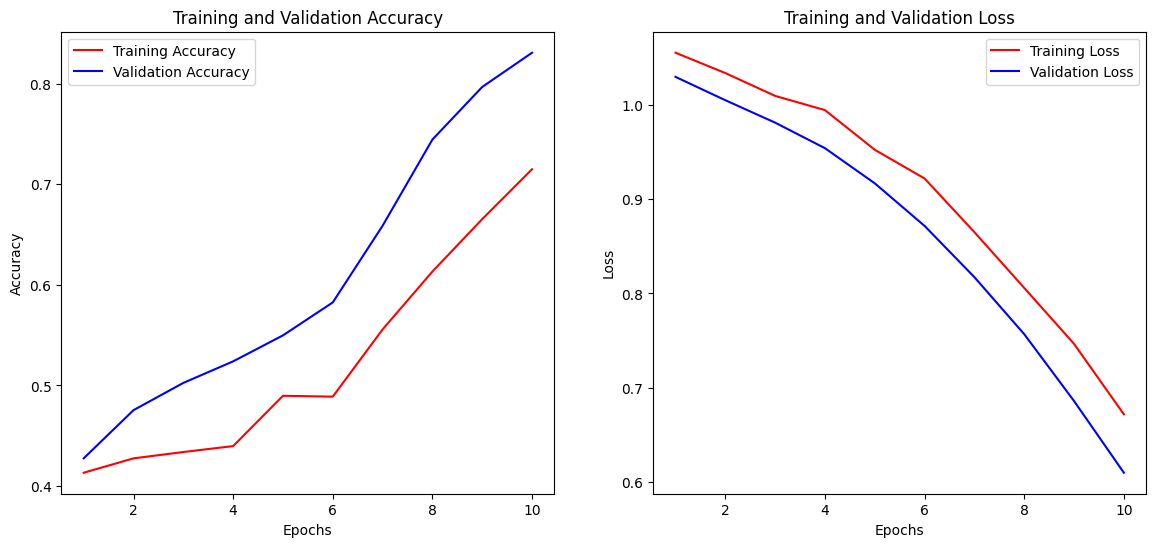

In [57]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy and loss
def plot_training_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Call the function to plot the curves
plot_training_curves(history)


TEST DATA

1/1 [==============================] - 1s 1s/step
Classification Report:
                   precision    recall  f1-score   support

  sexual_violence       0.91      0.81      0.85      1128
physical_violence       0.82      0.91      0.86      1060
     non_violence       0.70      0.71      0.71       459

         accuracy                           0.83      2647
        macro avg       0.81      0.81      0.81      2647
     weighted avg       0.84      0.83      0.83      2647

Confusion Matrix:


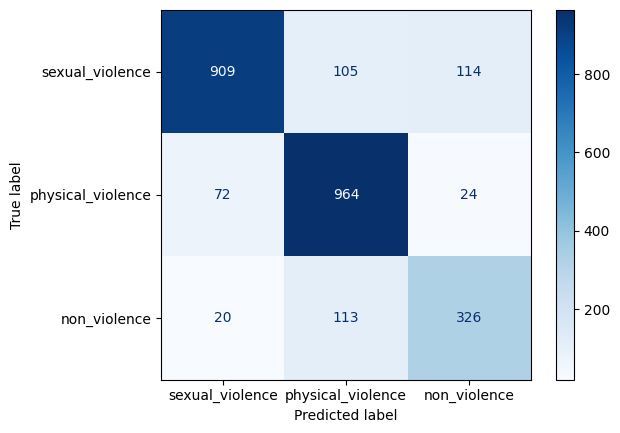

In [58]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Function to generate predictions and evaluate the model on the test set
def evaluate_model_on_test_data(model, test_dataset):
    y_true = []
    y_pred = []

    # Loop through the test dataset to get predictions and true labels
    for batch in test_dataset:
        text_batch, label_batch = batch
        predictions = model.predict(text_batch)
        y_true.extend(label_batch.numpy())  # Collect true labels
        y_pred.extend(np.argmax(predictions, axis=1))  # Collect predicted labels (class with highest probability)

    # Generate classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=['sexual_violence', 'physical_violence', 'non_violence']))

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['sexual_violence', 'physical_violence', 'non_violence'])

    # Plot confusion matrix
    print("Confusion Matrix:")
    cm_display.plot(cmap=plt.cm.Blues)
    plt.show()

# Call the function to evaluate the model on test data
evaluate_model_on_test_data(cnn_classifier_model, test_ds)

Class Weighting: NON VIOLENCE

In [59]:
# Calculate class weights based on the training dataset distribution
from sklearn.utils import class_weight
import numpy as np

# Assuming your labels are stored in y_train
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Convert to dictionary format
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Pass class weights to the fit method
history = cnn_classifier_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stopping],
    class_weight=class_weights_dict  # Pass the class weights
)


Epoch 1/10
75/75 [==============================] - 50s 578ms/step - loss: 0.6790 - accuracy: 0.7526 - val_loss: 0.5718 - val_accuracy: 0.8249
Epoch 2/10
75/75 [==============================] - 43s 570ms/step - loss: 0.5765 - accuracy: 0.7976 - val_loss: 0.5139 - val_accuracy: 0.8470
Epoch 3/10
75/75 [==============================] - 43s 570ms/step - loss: 0.5082 - accuracy: 0.8257 - val_loss: 0.4674 - val_accuracy: 0.8696
Epoch 4/10
75/75 [==============================] - 43s 570ms/step - loss: 0.4360 - accuracy: 0.8572 - val_loss: 0.4119 - val_accuracy: 0.8974
Epoch 5/10
75/75 [==============================] - 43s 570ms/step - loss: 0.3839 - accuracy: 0.8753 - val_loss: 0.3729 - val_accuracy: 0.9074
Epoch 6/10
75/75 [==============================] - 43s 571ms/step - loss: 0.3236 - accuracy: 0.9005 - val_loss: 0.3358 - val_accuracy: 0.9188
Epoch 7/10
75/75 [==============================] - 43s 571ms/step - loss: 0.2870 - accuracy: 0.9160 - val_loss: 0.3118 - val_accuracy: 0.9200

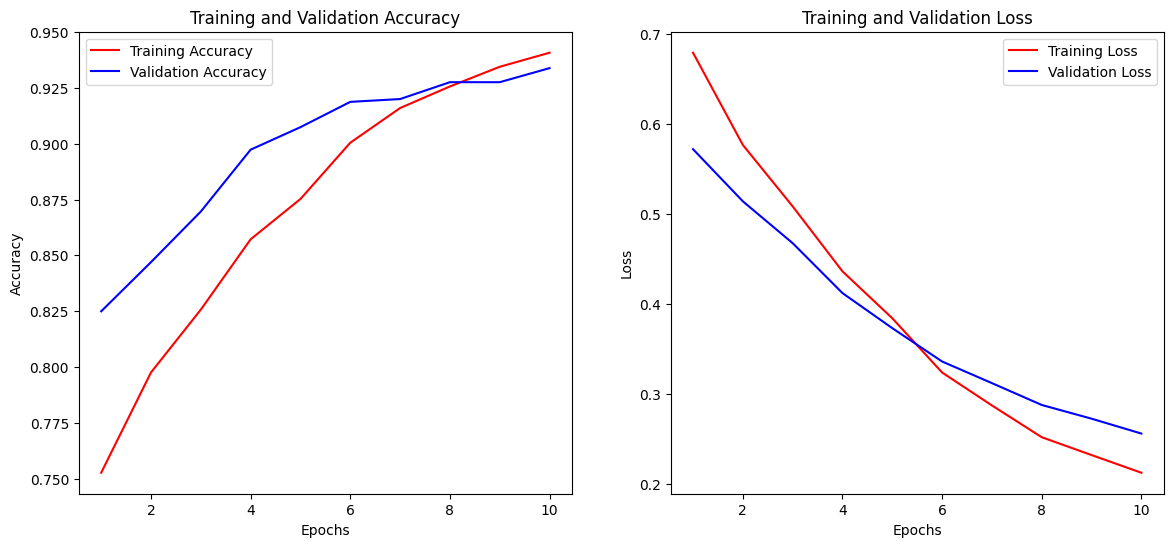

1/1 [==============================] - 0s 52ms/step
Classification Report:
                   precision    recall  f1-score   support

  sexual_violence       0.96      0.92      0.94      1128
physical_violence       0.95      0.95      0.95      1060
     non_violence       0.85      0.93      0.89       459

         accuracy                           0.93      2647
        macro avg       0.92      0.93      0.93      2647
     weighted avg       0.94      0.93      0.93      2647

Confusion Matrix:


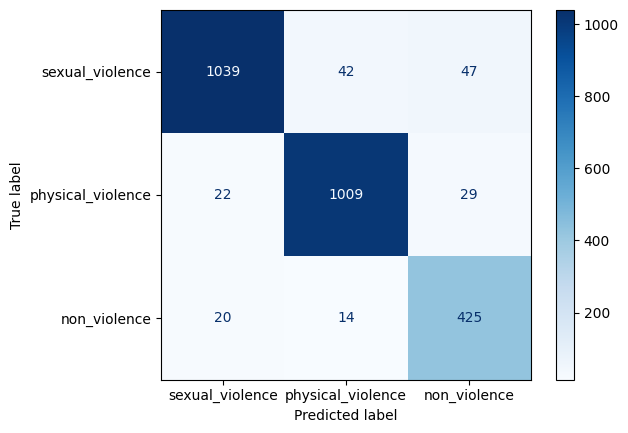

In [60]:
# Step 4: Plot the training and validation accuracy and loss after training
plot_training_curves(history)

# Step 5: Evaluate the model on the test dataset after training
evaluate_model_on_test_data(cnn_classifier_model, test_ds)

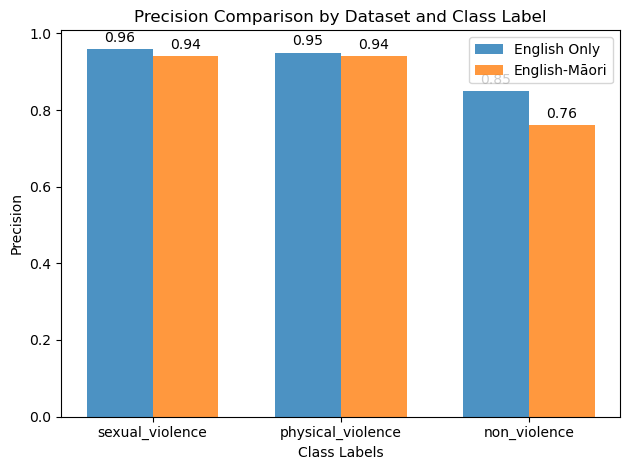

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Data for precision
labels = ['sexual_violence', 'physical_violence', 'non_violence']
english_only = [0.96, 0.95, 0.85]
english_maori = [0.94, 0.94, 0.76]

# X-axis setup
x = np.arange(len(labels))
width = 0.35

# Plot
fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, english_only, width, label='English Only', alpha=0.8)
bars2 = ax.bar(x + width/2, english_maori, width, label='English-Māori', alpha=0.8)

# Labels and titles
ax.set_xlabel('Class Labels')
ax.set_ylabel('Precision')
ax.set_title('Precision Comparison by Dataset and Class Label')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Adding precision values on top of bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # Offset text above the bar
                    textcoords="offset points",
                    ha='center', va='bottom')

# Show plot
plt.tight_layout()
plt.show()


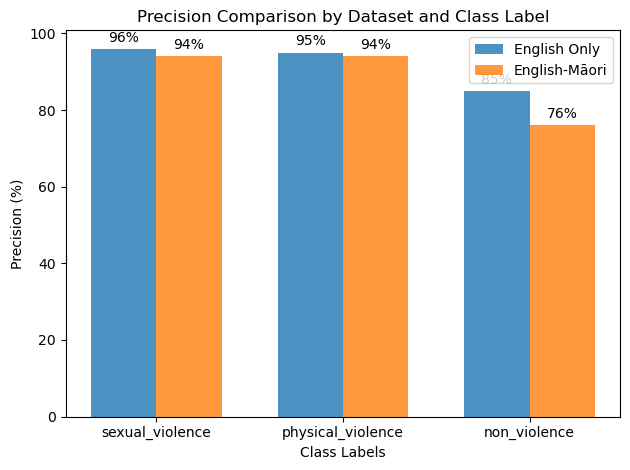

In [ ]:
# Data for precision (converted to percentage)
english_only_precision = [96, 95, 85]  # Converted to percentage
english_maori_precision = [94, 94, 76]  # Converted to percentage

# Plot
fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, english_only_precision, width, label='English Only', alpha=0.8)
bars2 = ax.bar(x + width/2, english_maori_precision, width, label='English-Māori', alpha=0.8)

# Labels and titles
ax.set_xlabel('Class Labels')
ax.set_ylabel('Precision (%)')
ax.set_title('Precision Comparison by Dataset and Class Label')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Adding precision values on top of bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.0f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # Offset text above the bar
                    textcoords="offset points",
                    ha='center', va='bottom')

# Show plot
plt.tight_layout()
plt.show()


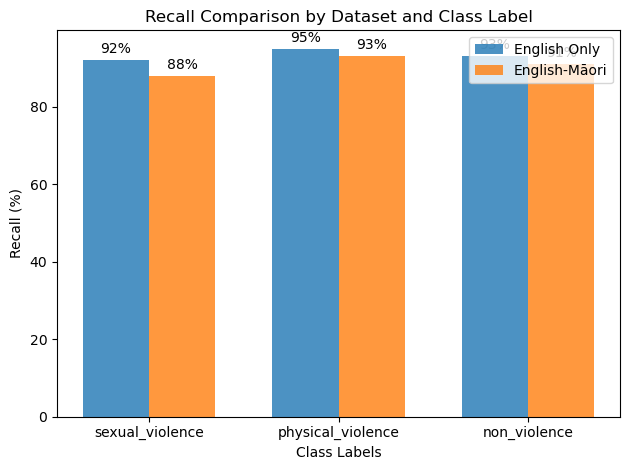

In [2]:
# Data for recall (converted to percentage)
labels = ['sexual_violence', 'physical_violence', 'non_violence']
english_only_recall = [92, 95, 93]  # Converted to percentage
english_maori_recall = [88, 93, 91]  # Converted to percentage

# X-axis setup
x = np.arange(len(labels))
width = 0.35

# Plot
fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, english_only_recall, width, label='English Only', alpha=0.8)
bars2 = ax.bar(x + width/2, english_maori_recall, width, label='English-Māori', alpha=0.8)

# Labels and titles
ax.set_xlabel('Class Labels')
ax.set_ylabel('Recall (%)')
ax.set_title('Recall Comparison by Dataset and Class Label')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Adding recall values on top of bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.0f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # Offset text above the bar
                    textcoords="offset points",
                    ha='center', va='bottom')

# Show plot
plt.tight_layout()
plt.show()


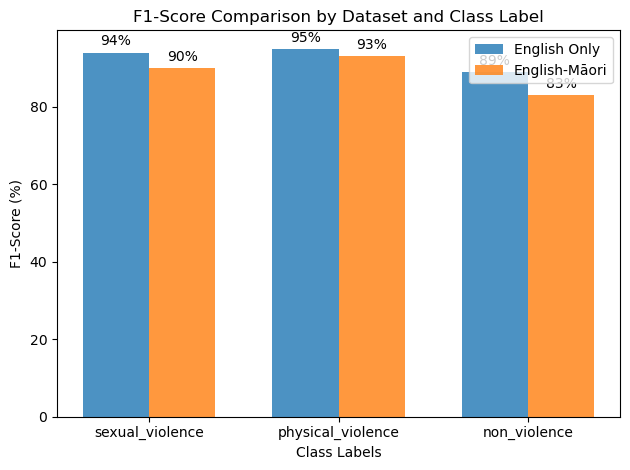

In [4]:
# Data for F1-score (converted to percentage)
english_only_f1 = [94, 95, 89]  # Converted to percentage
english_maori_f1 = [90, 93, 83]  # Converted to percentage

# Plot
fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, english_only_f1, width, label='English Only', alpha=0.8)
bars2 = ax.bar(x + width/2, english_maori_f1, width, label='English-Māori', alpha=0.8)

# Labels and titles
ax.set_xlabel('Class Labels')
ax.set_ylabel('F1-Score (%)')
ax.set_title('F1-Score Comparison by Dataset and Class Label')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Adding F1 values on top of bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.0f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # Offset text above the bar
                    textcoords="offset points",
                    ha='center', va='bottom')

# Show plot
plt.tight_layout()
plt.show()


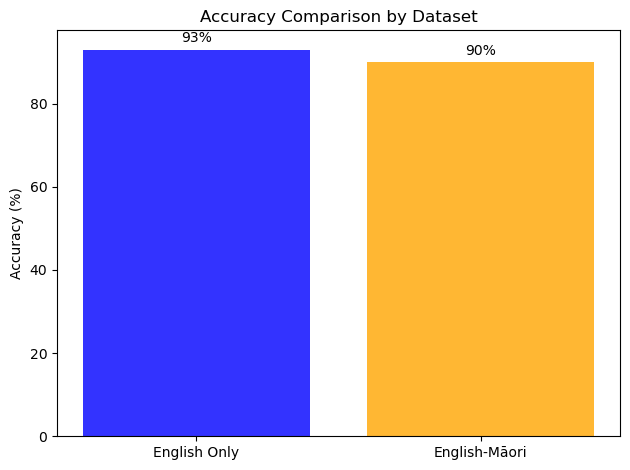

In [5]:
# Data for accuracy (converted to percentage)
datasets = ['English Only', 'English-Māori']
accuracy = [93, 90]  # Converted to percentage

# Plot
fig, ax = plt.subplots()
bars = ax.bar(datasets, accuracy, color=['blue', 'orange'], alpha=0.8)

# Labels and title
ax.set_ylabel('Accuracy (%)')
ax.set_title('Accuracy Comparison by Dataset')

# Adding accuracy values on top of bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.0f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # Offset text above the bar
                textcoords="offset points",
                ha='center', va='bottom')

# Show plot
plt.tight_layout()
plt.show()


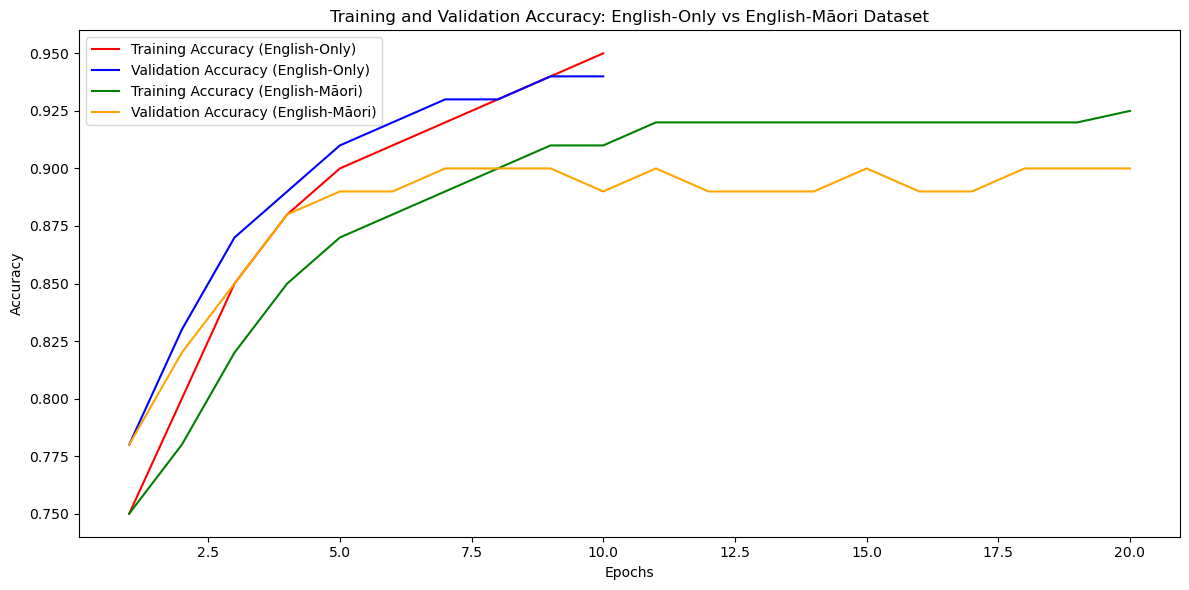

In [8]:
# Plot for training and validation accuracy in both datasets
plt.figure(figsize=(12, 6))

# English-only dataset
plt.plot(epochs_english_only, training_accuracy_english_only, label='Training Accuracy (English-Only)', color='red')
plt.plot(epochs_english_only, validation_accuracy_english_only, label='Validation Accuracy (English-Only)', color='blue')

# English-Māori dataset
plt.plot(epochs_english_maori, training_accuracy_english_maori, label='Training Accuracy (English-Māori)', color='green')
plt.plot(epochs_english_maori, validation_accuracy_english_maori, label='Validation Accuracy (English-Māori)', color='orange')

# Titles and labels
plt.title('Training and Validation Accuracy: English-Only vs English-Māori Dataset')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show plot
plt.tight_layout()
plt.show()


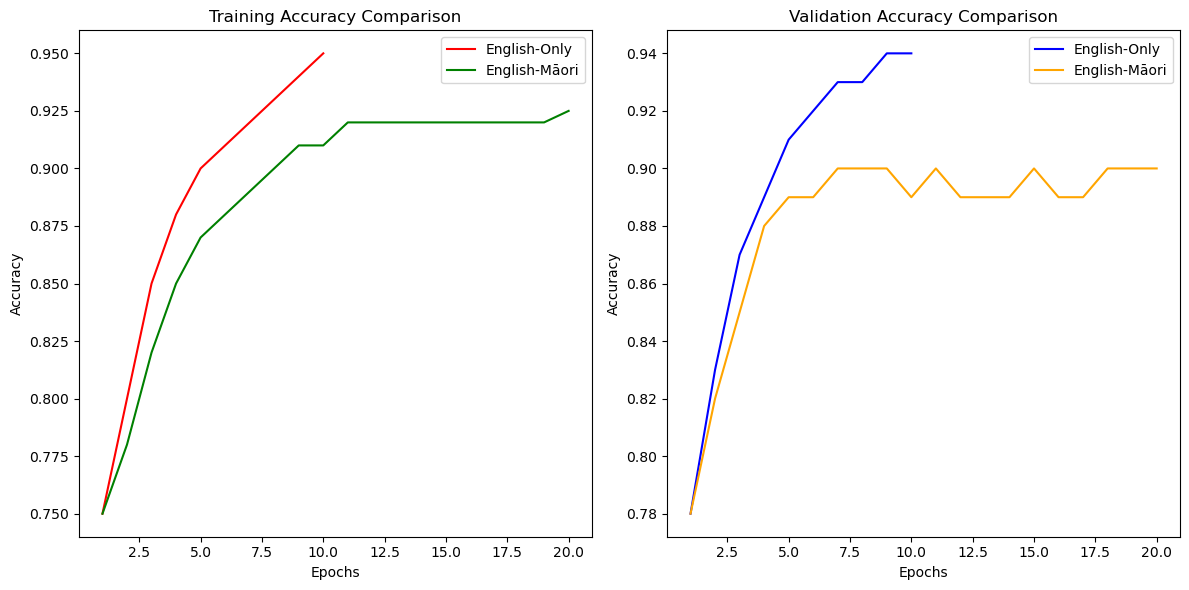

In [9]:
# Plot for training accuracy comparison
plt.figure(figsize=(12, 6))

# Training Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_english_only, training_accuracy_english_only, label='English-Only', color='red')
plt.plot(epochs_english_maori, training_accuracy_english_maori, label='English-Māori', color='green')
plt.title('Training Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_english_only, validation_accuracy_english_only, label='English-Only', color='blue')
plt.plot(epochs_english_maori, validation_accuracy_english_maori, label='English-Māori', color='orange')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show plot
plt.tight_layout()
plt.show()


In [63]:
import numpy as np

# Function to evaluate model predictions and track all misclassified examples in the English-only dataset
def evaluate_model_and_find_all_misclassified_english_sentences(model, test_data):
    y_true = []
    y_pred = []
    misclassified_tweets = {
        "sexual_violence": [],
        "physical_violence": [],
        "non_violence": []
    }

    # Class label names for reference
    class_names = ['sexual_violence', 'physical_violence', 'non_violence']

    for batch in test_data:
        text_batch, label_batch = batch
        predictions = model.predict(text_batch)
        y_true.extend(label_batch.numpy())  # Collect true labels
        predicted_classes = np.argmax(predictions, axis=1)  # Get predicted labels

        for tweet, true_label, pred_label in zip(text_batch, label_batch.numpy(), predicted_classes):
            if true_label != pred_label:
                # Decode the tweet to a string (for TensorFlow)
                tweet_text = tweet.numpy().decode('utf-8')
                # Append all misclassified tweets, grouped by true label
                class_label = class_names[true_label]
                misclassified_tweets[class_label].append({
                    'tweet': tweet_text,
                    'predicted_class': class_names[pred_label]
                })

    return misclassified_tweets

# Assuming 'test_ds' is the test dataset and 'cnn_classifier_model' is the trained model
misclassified_english_tweets = evaluate_model_and_find_all_misclassified_english_sentences(cnn_classifier_model, test_ds)

# Function to print all misclassified tweets for the English-only dataset
def print_all_misclassified_english_tweets(misclassified_tweets):
    for true_class, tweets in misclassified_tweets.items():
        print(f"True Class: {true_class}")
        if tweets:
            for idx, tweet_info in enumerate(tweets, 1):
                print(f"  {idx}. Tweet: {tweet_info['tweet']}")
                print(f"     Predicted Class: {tweet_info['predicted_class']}")
        else:
            print("  No misclassified tweets.")
        print("\n")

# This function call would print the list of all misclassified tweets for the English-only dataset:
print_all_misclassified_english_tweets(misclassified_english_tweets)


1/1 [==============================] - 0s 50ms/step
True Class: sexual_violence
  1. Tweet: #NAME?
     Predicted Class: non_violence
  2. Tweet: MY STORY: How I Was Brutally Defiled By A Friend While Trying To Get A Job (PLUS...    
     Predicted Class: physical_violence
  3. Tweet: The confidence though !!!!!  He was like "Yes b!tches, that was me, I got spanked once on my buttocks" ðððð»
     Predicted Class: physical_violence
  4. Tweet: MY STORY: âMy Father defiled Me, And My Mother Blamed Meâ: I was defiled from age of 12 to 16 and ...  
     Predicted Class: physical_violence
  5. Tweet: LANTERNAPOST: was inebriated after I defiled my daughter but she turned into not a father:  
     Predicted Class: physical_violence
  6. Tweet: Uhgghhhg I just got he called me ugly uhgh I'm done I'm so done uhg mhhhm aaaaa)))))
     Predicted Class: physical_violence
  7. Tweet: Dear Dia- I was defiled by my step grand father.  
     Predicted Class: physical_violence
  8. Twee